Note: This is derived from https://realpython.com/linear-regression-in-python/

In [150]:
%matplotlib inline

import csv
import datetime as dt
from calendar import monthrange, isleap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def days_in_month(year, month):
    return monthrange(year, month)[1]

In [4]:
data = pd.read_excel('NetLoad_for_UCM_2030_2060.xlsx', sheet_name='Price - After ES', index_col=[0], header=0, skiprows=[1])

In [5]:
data.head()

,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,...,2054,2055,2056,2057,2058,2059,2060,Unnamed: 32,Unnamed: 33,Unnamed: 34
Hour,,,,,,,,,,,,,,,,,,,,,
1,33.862370,31.041192,28.433732,25.764267,23.174947,20.495386,17.919723,15.149398,11.924823,9.893008,...,-40.762233,-44.451077,-48.083527,-51.819287,-55.406771,-59.129527,-62.788841,NaN,NaN,-168.764069
2,33.858551,31.030875,28.397701,25.766204,23.173242,20.422084,17.923006,15.132969,11.924687,9.911211,...,-40.797494,-44.421675,-48.105175,-51.820094,-55.450067,-59.126900,-62.835097,NaN,NaN,NaN
3,33.864967,31.040004,28.360954,25.765016,23.183642,20.406493,17.912341,15.132552,11.836695,9.835317,...,-40.784414,-44.458842,-48.069941,-51.798267,-55.597835,-59.131188,-62.833399,NaN,NaN,NaN
4,33.864266,31.030964,28.362409,25.776898,23.181188,20.411745,17.908273,15.143091,11.839563,9.819261,...,-40.763660,-44.484327,-48.069615,-51.786596,-55.510944,-59.335515,-62.810279,NaN,NaN,NaN
5,33.862054,31.032895,28.355487,25.769544,23.171002,20.416612,17.908928,15.131182,11.881457,9.831375,...,-40.789983,-44.456854,-48.104060,-51.784091,-55.606491,-59.322386,-62.789015,NaN,NaN,NaN


## Some demonstrative time series

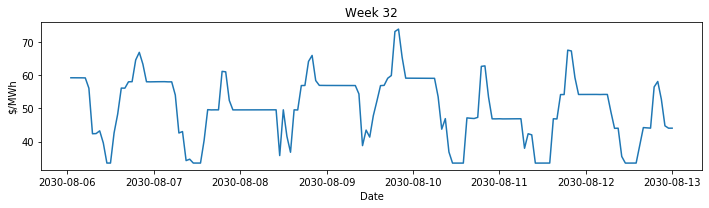

In [6]:
weeks = range(1,53)
df = data[2030]
df.index = data.index = pd.date_range(start='2030-01-01', freq='H', periods=len(df))
for week in weeks:
    hour = (week-1)*168 + 1
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(df.iloc[hour:hour+168])
    ax.set_title('Week {}'.format(week))
    ax.set_xlabel('Date')
    ax.set_ylabel('$/MWh')
    plt.tight_layout()
    fig.savefig('timeseries/week_{:02}.png'.format(week), dpi=300)
    if week == 32:
        plt.show()
    plt.close()

## Main processing

### Key functions

`get_split`: This is a basic function that splits a series of x-y pairs into two. It finds the split between an initial lower bound and upper bound (x_min and x_max, respectively) by finding the two contiguous subsets of y that minimize the squared difference between the sum of squares associated with the two sets.

`get_splits`: This function uses `get_split` to recursively subsplit a series. It currently can only divide by two. I.e., there must be either 1, 2, 4, 8, etc. total number of pieces as a result of the split. This is defined by `max_k` (as in 2^k), which is the square of two associated with the desired total number of pieces.

In [7]:
def get_split(x, y, debug=False, trial='Demo'):
    predictions = []
    stats = []
    objs = []
    splits = []
    cnt = 0
    if len(x) == 0 or len(y) == 0:
#         print('returning nothing for trial {}, because...'.format(trial))
#         if len(x) == 0:
#             print('x:', x)
#         if len(y) == 0:
#             print('y:', y)

        return None
    
    lb = min(x)
    ub = max(x)
    split = (ub + lb) / 2
    best_split = None
    old_split = 1e6
    tol = 0.025
    old_obj = 1e6
    best_obj = 1e6
    best_objs = []
    search_complete = False
    best_idx = None
    
#     if debug:
#         print('STARTING INFO:')
#         print('split:', split)
#         print('xmin:', min(x))
#         print('lb:', lb)
#         print('ub:', ub)

    
    while not search_complete and cnt < 15:
        cnt += 1
        splits.append(rnd(split, 1))
#         if debug:
#             print('split:', split)
#             print('xmin:', min(x))
#             print('lb:', lb)
        x1 = np.array([_x for _x in x if _x <= split])
        l1 = len(x1)
        l2 = len(x) - l1
        x2 = np.array(x[-l2:])
        
        y1 = np.array(y[:l1])
        y2 = np.array(y[l1:])
        
        if len(y1) < 2 or len(y2) < 2:
#             search_complete = True
#             return best_split
            print(split)
        
        p1 = np.full(l1, y1.mean())
        p2 = np.full(l2, y2.mean())
        
        ss1 = ss(y1, p1)
        ss2 = ss(y2, p2)

        obj = (ss1 - ss2)**2
        best_obj = min(obj, best_obj)
        if best_obj < old_obj:
            best_split = split
            best_idx = l1
    #         if best_obj in best_objs:
    #             print('best_obj', best_obj)
    #             print(best_objs)
    #             break # we've been here before
    #         best_objs.append(best_obj)

        old_obj = obj
        rel_diff = abs((split - old_split) / old_split)
#         print('relative difference:', rel_diff)
    #     print('old_obj', old_obj)
    #     print('obj', obj)
        if rel_diff <= tol:
    #         print(obj_diff / old_obj, tol)
            search_complete = True
        else:
            old_split = split
            if ss1 < ss2: # look higher
                lb = split
                split += (ub - split) / 2
            else: # look lower
                ub = split
                split -= (split - lb) / 2

        objs.append(rel_diff)
        stats.append((rnd(ss1, 3), rnd(ss2, 3)))
        predictions.append(((x1, p1), (x2, p2)))
        
    if debug:
        n = len(predictions)
        
        if debug:
            fig1, axes = plt.subplots(n, 1, figsize=(8, 3*n))
            for i, predictionset in enumerate(predictions):
                ax = axes[i]
                ax.plot(x, y, label='Original prices')
                for j, (xp, yp) in enumerate(predictionset):
                    ax.plot(xp, yp, label='Piece {}, SS={}'.format(j+1, stats[i][j]))
                ax.set_xlabel('Percent of day')
                ax.set_ylabel('Price ($/GWh?)')
                ax.set_title('Split = {}%'.format(splits[i]))
                ax.legend(loc='lower left')
                ax.axvline(splits[i], color='black', linestyle='dashed')
            plt.tight_layout()
            fig1.savefig('demo search steps - {}.png'.format(trial))
        
        fig2, ax = plt.subplots(figsize=(8, 3))
        ax.plot(x, y, label='Original prices')
        for j, (xp, yp) in enumerate(predictions[-1]):
            ax.plot(xp, yp, label='Piece {}, SS={}'.format(j+1, stats[-1][j]))
        ax.set_xlabel('Percent of period')
        ax.set_ylabel('Price ($/GWh?)')
        ax.set_title('{} Final split = {}%'.format(trial, splits[-1]))
        ax.legend(loc='lower left')
        plt.tight_layout()
        fig2.savefig('demo final search step - {}.png'.format(trial))
        
        if debug:
            fig3, ax = plt.subplots(figsize=(6, 4))
            ax.plot(objs)
            ax.set_ylabel('Split difference (tol={:03})'.format(tol))
            ax.set_xlabel('Iteration')
            ax.set_title('{} Solution Convergence'.format(trial))
            ax.axhline(tol, color='black', linestyle='dashed')
            plt.tight_layout()
            fig3.savefig('demo convergence - {}.png'.format(trial))
        
        plt.show()

    return best_split

In [8]:
def get_splits(x, y, splits=None, k=1, max_k=1, debug=False, trial='Demo'):
#     print('SPLITS', splits)
    if splits is None:
        splits = []
    if debug:
        print('k:', k)
        print('splits:', splits)
    split = get_split(x, y, debug=False, trial=trial)
    if split is None:
        get_split(x, y, debug=True, trial=trial) # this will produce graphs
        return splits
    if debug:
        print('idx:', idx)
    if split not in splits:
        splits.append(split)
    if k == max_k:
        if debug:
            print('returning:', splits)
        return splits
    else:
        idx = len([_x for _x in x if _x <= split])
        x1, x2 = x[:idx], x[idx:]
        y1, y2 = y[:idx], y[idx:]
#         print('getting first split with', y1)
        splits = get_splits(x1, y1, splits=splits, k=k+1, max_k=max_k, debug=debug, trial='K{}P1'.format(k+1))
#         print('getting second split')
        splits = get_splits(x2, y2, splits=splits, k=k+1, max_k=max_k, debug=debug, trial='K{}P2'.format(k+1))
        return splits

## Main processing script

### Historical

In [139]:
# read data
hist = pd.read_csv('historical-2009.csv', index_col=[0])
hist.index = pd.date_range(start='2009-01-01', periods=len(hist), freq='H')
hist.head()

,Electricity Price [$/MWh]
2009-01-01 00:00:00,55.79
2009-01-01 01:00:00,53.90
2009-01-01 02:00:00,53.31
2009-01-01 03:00:00,51.95
2009-01-01 04:00:00,49.83


In [155]:
period = 'future'
step = 'monthly'

if step == 'daily':
    MAX_K = 2
else:
    MAX_K = 3
    
if period == 'historical':
    years = range(2000, 2016)
else:
    years = range(2030, 2061)
    
months = range(1,13)

blocks = []
prices = []
index_dates = []

for year in years:
    m1 = months[0]
    m2 = months[-1]
    start = dt.date(year, m1, 1)
    end = dt.date(year, m2, days_in_month(year, m2))
    freq = step[0].upper()
    dates = pd.date_range(start=start, end=end, freq=freq)
    
    if period == 'historical':
        data_year = 2009
    else:
        date.year
    
    s = hist[(hist.index.year==data_year)]
    
    for date in dates:
        index_dates.append(date)
        
        # subset the data
        if step == 'monthly':
            _s = s[s.index.month==date.month]
        else: # note parentheses are important here
            if date.month == 2 and date.day == 29:
                data_day = 28
            else:
                data_day = date.day
            _s = s[(s.index.year == data_year) & (s.index.month == date.month) & (s.index.day == data_day)]
        
        y0 = np.array(sorted(_s.values, reverse=True))
        x = np.arange(1, len(y0)+1)
        x0 = x * 100 / x.max()

        splits = get_splits(x0, y0, debug=False, max_k=MAX_K, trial='K1')
        splits = sorted(splits)

        split_indices = []
        for split in splits:
            split_indices.append(len([_x for _x in x0 if _x <= split]))
        _blocks = []
        _prices = []
        all_indices = split_indices + [len(x0)]
        for j, idx in enumerate(all_indices):
            a = split_indices[j-1] if j else 0
            _x = x0[a:idx]
            if j == 0:
                block = max(_x)
            else:
                block = max(_x) - x0[last_idx-1]
            last_idx = idx
            price = y0[a:idx].mean()
            _blocks.append(block)
            _prices.append(price)

        blocks.append(_blocks)
        prices.append(_prices)

# index
date_index = pd.DatetimeIndex(index_dates)

# blocks
df_blocks = pd.DataFrame(data=blocks, index=date_index, columns=range(1, len(_blocks)+1))
df_blocks.index.name = 'Date'
df_blocks.to_csv('piecewise_blocks_{}_{}.csv'.format(step, period))

# prices
df_prices = pd.DataFrame(data=prices, index=date_index, columns=range(1, len(_blocks)+1))
df_prices.index.name = 'Date'
df_prices.to_csv('piecewise_prices_DpMWh_{}_{}.csv'.format(step, period))

print('{} {} done!'.format(period, step))

future monthly done!


In [114]:
df_prices.head()

,1,2,3,4
Date,,,,
2009-01-01,70.1550,61.728000,58.227143,52.950000
2009-01-02,74.9725,64.952857,59.586667,51.524286
2009-01-03,80.0620,73.038000,64.306667,53.668333
2009-01-04,81.3560,74.700000,66.863333,55.960000
2009-01-05,80.4440,73.641000,67.660000,57.086667


### Projected

...and let's also create a graph from what we just saved:

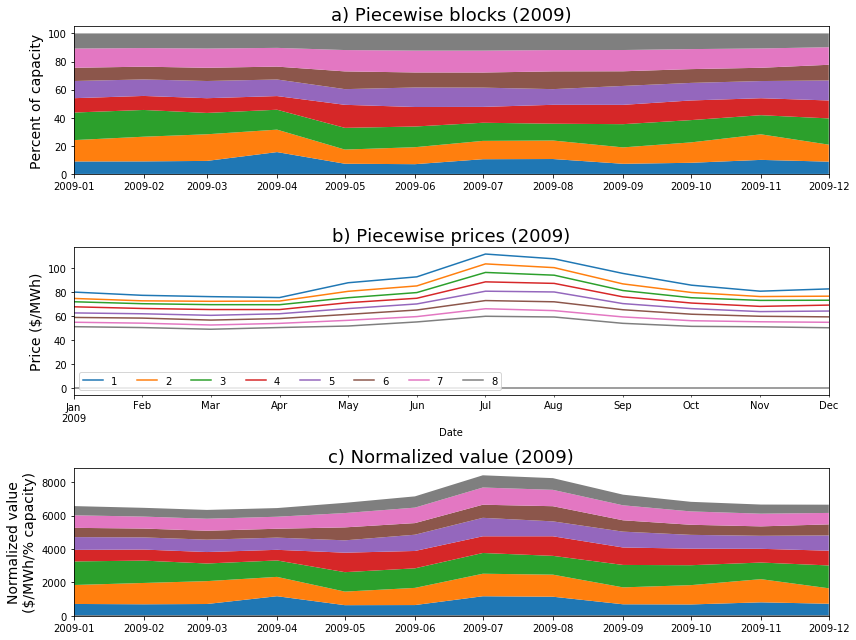

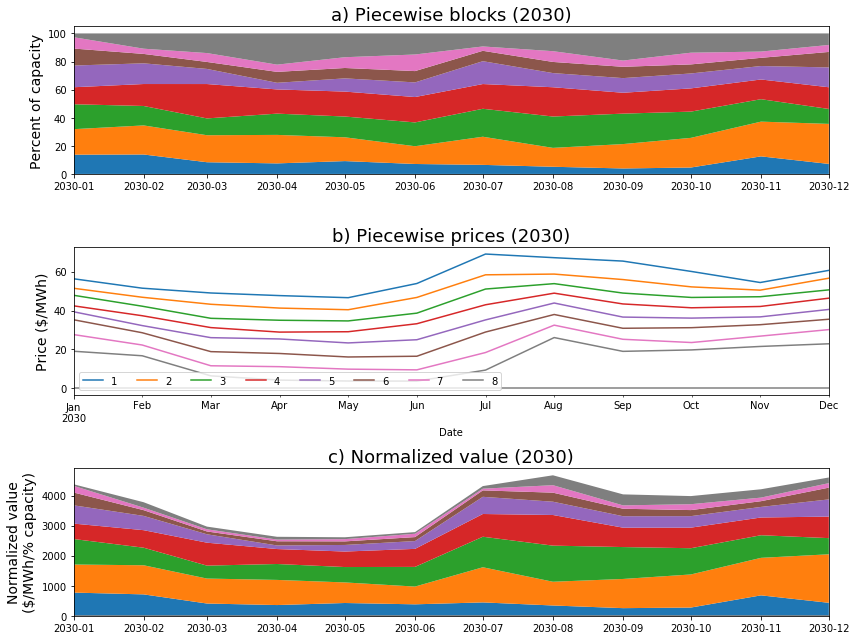

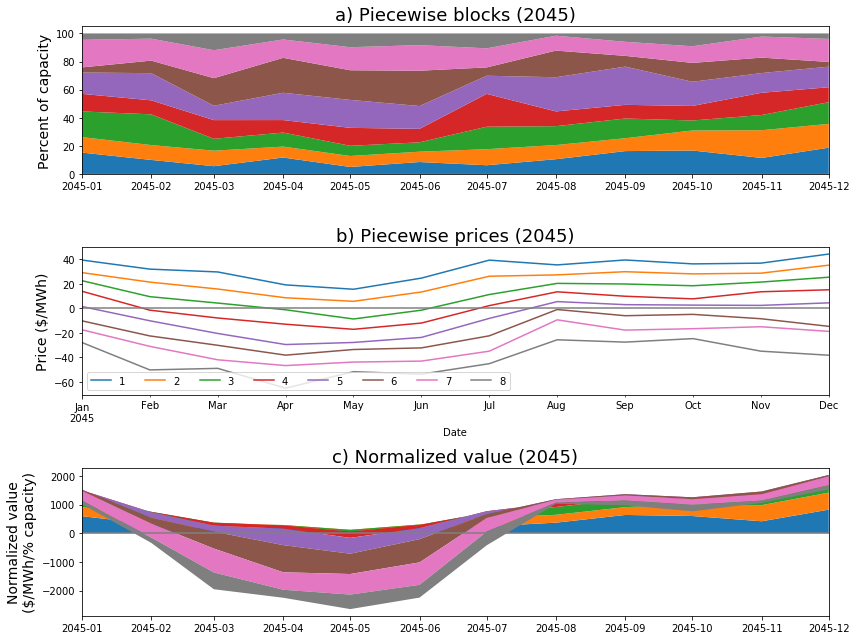

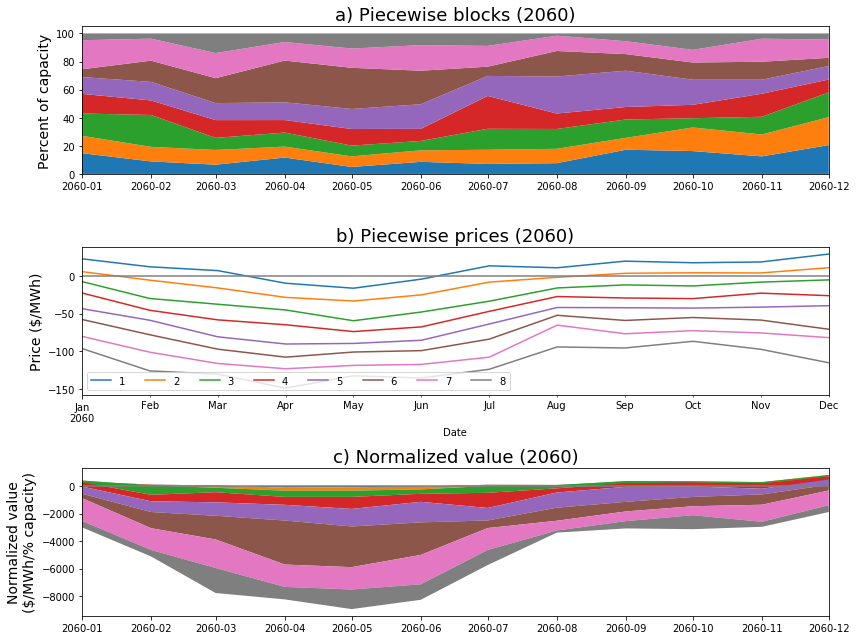

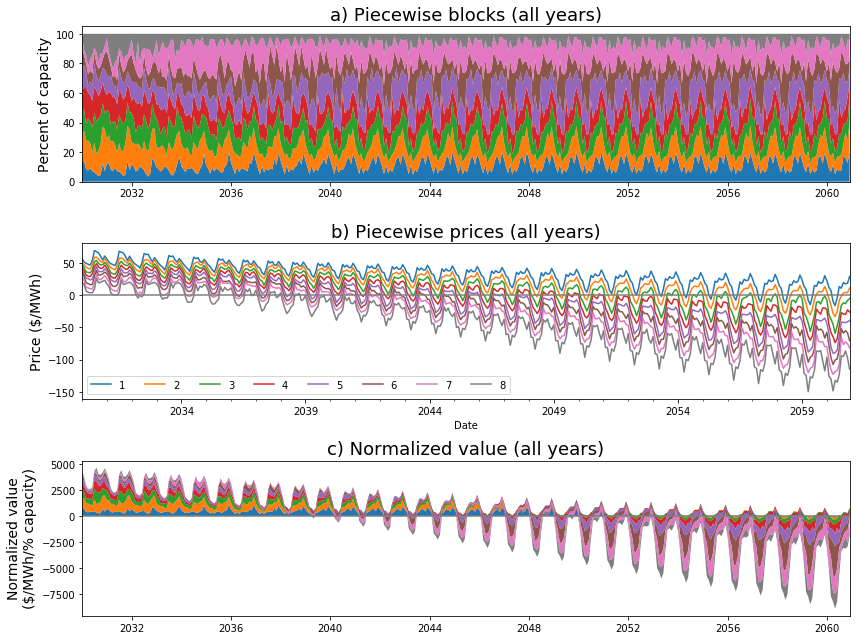

In [34]:
TITLE_SIZE = 18
AXIS_SIZE = 14
for year in [2009, 2030, 2045, 2060, 'all years']:
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 9))
    ax1, ax2, ax3 = axes

    if year == 2009:
        dfb = df_blocks_hist[df_blocks_hist.index.year == year]
        dfp = df_prices_hist[df_prices_hist.index.year == year]
    elif year == 'all years':
        dfb = df_blocks
        dfp = df_prices
    else:
        dfb = df_blocks[df_blocks.index.year == year]
        dfp = df_prices[df_prices.index.year == year]
    
    ax1.stackplot(dfb.index, dfb.values.T)
    ax1.set_title('a) Piecewise blocks ({})'.format(year), fontsize=TITLE_SIZE)
    ax1.set_ylabel('Percent of capacity', fontsize=AXIS_SIZE)

    dfp.plot(ax=ax2)
    ax2.axhline(0, color='grey')
    ax2.set_title('b) Piecewise prices ({})'.format(year), fontsize=TITLE_SIZE)
    ax2.set_ylabel('Price ($/MWh)', fontsize=AXIS_SIZE)
    ax2.legend(ncol=8, loc='lower left')

    df = dfp * dfb
    ax3.stackplot(df.index, df.values.T)
    ax3.axhline(0, color='grey')
    ax3.set_title('c) Normalized value ({})'.format(year), fontsize=TITLE_SIZE)
    ax3.set_ylabel('Normalized value\n($/MWh/% capacity)', fontsize=AXIS_SIZE)

    for ax in axes:
        ax.set_xlim(dfb.index[0], dfb.index[-1])
    #     ax.xaxis.set_ticks(np.arange(start, end, stepsize))

    plt.tight_layout()
    fig.savefig('aggregated charts/monthly block timeseries - {}.png'.format(year), dpi=600)
    plt.show()
    plt.close()

### Supplemental scripts (for graphs)

In [16]:
MAX_K = 3
years = range(2030, 2061)
months = range(1,13)
for year in years:
#     print(year)
    s = data[year]
    s.index = data.index = pd.date_range(start='2030-01-01', freq='H', periods=len(s))
    s.index.name = 'date'
    for month in months:
        yearmonth_pretty = date(year, month, 1).strftime('%B %Y')
        yearmonth = '{}-{:02}'.format(year, month)
        _s = s[s.index.month==month]
        y0 = np.array(sorted(_s.values, reverse=True))
        x = np.arange(1, len(y0)+1)
        x0 = x * 100 / x.max()

        splits = get_splits(x0, y0, debug=False, max_k=MAX_K, trial='K1')
        splits = sorted(splits)
        split_indices = []
    #     print('final_splits:', splits)
    #     print(x0[-5:])
        for split in splits:
            split_indices.append(len([_x for _x in x0 if _x <= split]))
    #     print('final_indices:', split_indices)

        fig, ax = plt.subplots(figsize=(8, 3.5))
        ax.plot(x0, y0, label='Original prices')
        for j, idx in enumerate(split_indices + [len(x0)]):
            a = split_indices[j-1] if j else 0
            _x = x0[a:idx]
            _y = np.full(idx - a, y0[a:idx].mean())
            split = _x[0] if len(_x) else 0.0
            if split:
                ax.axvline(split, color='grey', linestyle='dotted')
            ax.plot(_x, _y, color=None, label='Piece {}, start: {:.1f}%'.format(j+1, split))
        ax.set_xlabel('% of month', fontsize=12)
        ax.set_ylabel('Marginal price ($/MWh)', fontsize=12)
    #     ax.set_title('Piecewise linearization of electricity prices (After ES) - {}'.format(yearmonth_pretty), fontsize=14)
        ax.set_title(yearmonth_pretty, fontsize=14)
        ax.set_ylim(min(0, y0.min()))
    #     handles, labels = ax.get_legend_handles_labels()
    #     ax.legend(handles[:2], ['Original prices', 'Linearized prices'], loc='lower left')
        ax.legend(loc='lower left')
        plt.tight_layout()
#         plt.show()
        fig.savefig('linearization charts/piecewise linearization - {}.png'.format(yearmonth), dpi=300)
        plt.close()

Same as above, but with custom chart

2030
2060


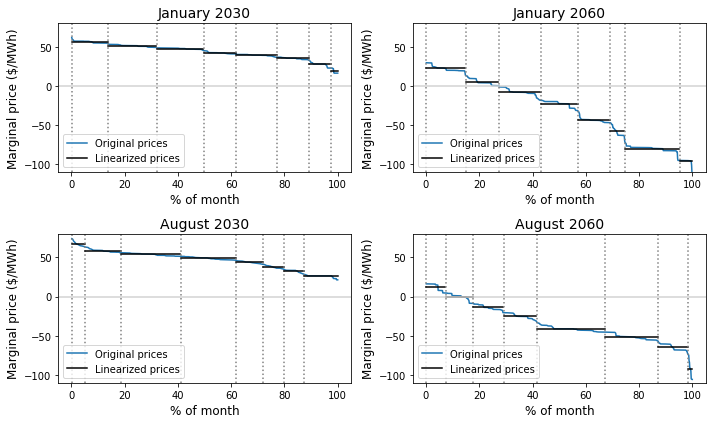

In [45]:
MAX_K = 3
# years = range(2030, 2061)
years = [2030, 2060]
months = [1, 8]

fig, axes = plt.subplots(len(years), len(months), figsize=(5*len(years), 3*len(months)))

for i, year in enumerate(years):
    print(year)
    s = data[year]
    s.index = data.index = pd.date_range(start='2030-01-01', freq='H', periods=len(s))
    s.index.name = 'date'
    for j, month in enumerate(months):
        yearmonth_pretty = date(year, month, 1).strftime('%B %Y')
        yearmonth = '{}-{:02}'.format(year, month)
        _s = s[s.index.month==month]
        y0 = np.array(sorted(_s.values, reverse=True))
        x = np.arange(1, len(y0)+1)
        x0 = x * 100 / x.max()

        splits = get_splits(x0, y0, debug=False, max_k=MAX_K, trial='K1')
        splits = sorted(splits)
        split_indices = []
        for split in splits:
            split_indices.append(len([_x for _x in x0 if _x <= split]))

        ax = axes[j][i]
        ax.plot(x0, y0, label='Original prices')
        for k, idx in enumerate(split_indices + [len(x0)]):
            a = split_indices[k-1] if k else 0
            _x = x0[a:idx]
            _y = np.full(idx - a, y0[a:idx].mean())
            split = _x[0] if len(_x) else 0.0
            if split:
                ax.axvline(split, color='grey', linestyle='dotted')
            ax.plot(_x, _y, color='black', label='Piece {}, start: {:.1f}%'.format(k+1, split))
        ax.axhline(0, color='lightgrey', linestyle='solid')
        ax.set_xlabel('% of month', fontsize=12)
        ax.set_ylabel('Marginal price ($/MWh)', fontsize=12)
#         ax.set_title('Piecewise linearization of electricity prices (After ES) - {}'.format(yearmonth_pretty), fontsize=14)
        ax.set_title(yearmonth_pretty, fontsize=14)
        ax.set_ylim(-110, 80)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ['Original prices', 'Linearized prices'], loc='lower left')
#         ax.legend(loc='lower left')
        
plt.tight_layout()
plt.show()
fig.savefig('demo - 2030 and 2060.png', dpi=300)
plt.close()

### Comparison of historical and future

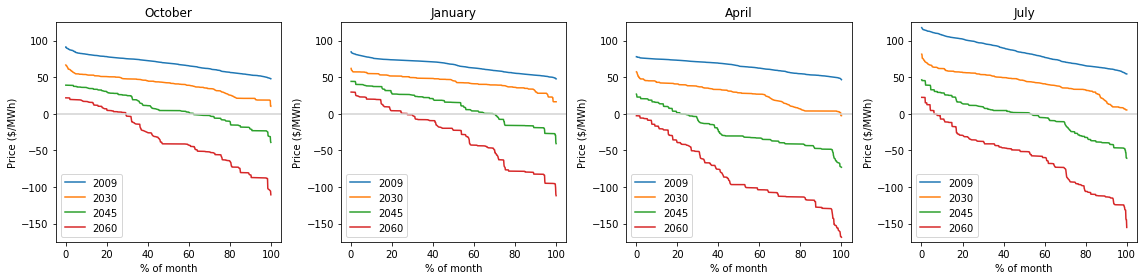

In [58]:
MAX_K = 3
# years = range(2030, 2061)
years = [2009, 2030, 2045, 2060]
months = [10, 1, 4, 7]

fig, axes = plt.subplots(1, len(months), figsize=(4*len(months), 4))

for i, year in enumerate(years):    
    if year == 2009:
        s = hist
    else:
        s = data[year]
        s.index = data.index = pd.date_range(start='2030-01-01', freq='H', periods=len(s))
        s.index.name = 'date'
    for j, month in enumerate(months):
        
        ax = axes[j]
        
        _s = s[s.index.month==month]
        y0 = np.array(sorted(_s.values, reverse=True))
        x = np.arange(1, len(y0)+1)
        x0 = x * 100 / x.max()
        ax.plot(x0, y0, label=year)
for j, month in enumerate(months):
    ax = axes[j]
    ax.set_title('{}'.format(date(1900,month,1).strftime('%B')))
    ax.set_xlabel('% of month')
    ax.set_ylabel('Price ($/MWh)')
    ax.set_ylim(-175, 125)
    ax.axhline(0, color='lightgrey')
#     ax.axvline(50, color='lightgrey')
    ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig('price duration curves overview.png', dpi=300)